# Dev Patel 23AIML047

## IPL Team Performance: Statistical Trends & Visual Analysis (2008–2023)

### Overview

This notebook investigates IPL match data to reveal how team performances and scoring have changed over time. The process starts with data cleaning, then calculates each team's total runs per match, and creates new features like run rate.

To highlight shifts, the data is split into two eras: before 2018 and after 2018. The following statistical tools are used:

- Shapiro-Wilk test for normality
- Linear regression for scoring trends
- Mann-Whitney U test for league vs playoff scoring
- Cohen’s d for effect size

These methods turn raw IPL records into actionable insights, showing how strategies and scoring have evolved.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro, mannwhitneyu, skew, kurtosis

In [ ]:
# Load IPL datasets
df_match = pd.read_csv('https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/IPL/match_data.csv')
df_info = pd.read_csv('https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/IPL/match_info_data.csv')

C:\Users\devdp\AppData\Local\Temp\ipykernel_1960\1000789008.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_match = pd.read_csv('https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/IPL/match_data.csv')


In [ ]:
df_match.head()

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed,cricsheet_id
0,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.1,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353
1,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.2,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353
2,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.3,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353
3,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.4,Gujarat Titans,Chennai Super Kings,Shubman Gill,WP Saha,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353
4,1370353,2023,2023-05-29,"Narendra Modi Stadium, Ahmedabad",1,0.5,Gujarat Titans,Chennai Super Kings,WP Saha,Shubman Gill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370353


In [ ]:
df_info.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1370353,2023,Ahmedabad,2023/05/29,Gujarat Titans,Chennai Super Kings,Chennai Super Kings,field,D/L,1,Chennai Super Kings,0,5,DP Conway,"Narendra Modi Stadium, Ahmedabad",Nitin Menon,RJ Tucker,KN Ananthapadmanabhan
1,1370352,2023,Ahmedabad,2023/05/26,Gujarat Titans,Mumbai Indians,Mumbai Indians,field,normal,0,Gujarat Titans,62,0,Shubman Gill,"Narendra Modi Stadium, Ahmedabad",Nitin Menon,RJ Tucker,J Madanagopal
2,1370351,2023,Chennai,2023/05/24,Mumbai Indians,Lucknow Super Giants,Mumbai Indians,bat,normal,0,Mumbai Indians,81,0,Akash Madhwal,"MA Chidambaram Stadium, Chepauk, Chennai",BNJ Oxenford,VK Sharma,CB Gaffaney
3,1370350,2023,Chennai,2023/05/23,Chennai Super Kings,Gujarat Titans,Gujarat Titans,field,normal,0,Chennai Super Kings,15,0,RD Gaikwad,"MA Chidambaram Stadium, Chepauk, Chennai",AK Chaudhary,CB Gaffaney,BNJ Oxenford
4,1359543,2023,Mumbai,2023/05/21,Sunrisers Hyderabad,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,8,C Green,"Wankhede Stadium, Mumbai",KN Ananthapadmanabhan,RJ Tucker,R Pandit


---

This section prepares and merges IPL match data for analysis. It computes each team's total runs per match, merges with match details, and adds new columns:

- `Era` (Pre-2018 or Post-2018)
- `run_rate` (runs per over, assuming 20 overs)
- Extracted year from the match date

# 1. Data Preparation & Feature Creation

In [ ]:
# Data cleaning and feature engineering
df_info['date'] = pd.to_datetime(df_info['date'], errors='coerce')

df_team_runs = df_match.groupby(['match_id', 'batting_team'])['runs_off_bat'].sum().reset_index()
df_team_runs.rename(columns={'runs_off_bat': 'total_runs'}, inplace=True)

df_merged = pd.merge(df_team_runs, df_info[['id', 'date', 'venue', 'team1', 'team2']],
                    left_on='match_id', right_on='id')
df_merged.drop(columns=['id'], inplace=True)

df_merged['Era'] = df_merged['date'].dt.year.apply(lambda y: 'Pre' if y < 2018 else 'Post')
df_merged['run_rate'] = df_merged['total_runs'] / 20.0
df_merged['year'] = df_merged['date'].dt.year

df_merged.tail()

,match_id,batting_team,total_runs,date,venue,team1,team2,Era,run_rate,year
2040,1370351,Mumbai Indians,166,2023-05-24,"MA Chidambaram Stadium, Chepauk, Chennai",Mumbai Indians,Lucknow Super Giants,Post,8.30,2023
2041,1370352,Gujarat Titans,223,2023-05-26,"Narendra Modi Stadium, Ahmedabad",Gujarat Titans,Mumbai Indians,Post,11.15,2023
2042,1370352,Mumbai Indians,164,2023-05-26,"Narendra Modi Stadium, Ahmedabad",Gujarat Titans,Mumbai Indians,Post,8.20,2023
2043,1370353,Chennai Super Kings,166,2023-05-29,"Narendra Modi Stadium, Ahmedabad",Gujarat Titans,Chennai Super Kings,Post,8.30,2023
2044,1370353,Gujarat Titans,210,2023-05-29,"Narendra Modi Stadium, Ahmedabad",Gujarat Titans,Chennai Super Kings,Post,10.50,2023


In [ ]:
# Shapiro-Wilk test for normality (Post-2018)
stat, pval = shapiro(df_merged[df_merged['Era']=='Post']['total_runs'])
print(f"Shapiro-Wilk p-value: {pval}")
if pval > 0.05:
    print("Data is approximately normal.")
else:
    print("Data is not normally distributed.")

Shapiro-Wilk p-value: 0.00028915925992835427
Data is not normally distributed.


**Interpretation:**

The p-value is below 0.05, so the data does not follow a normal distribution. This means non-parametric tests are more suitable for further analysis.

# 2. Shapiro-Wilk Test for Both Eras

In [ ]:
pre_scores = df_merged[df_merged['Era'] == 'Pre']['total_runs']
post_scores = df_merged[df_merged['Era'] == 'Post']['total_runs']

pre_norm = shapiro(pre_scores.sample(n=500, random_state=1) if len(pre_scores) > 500 else pre_scores)
post_norm = shapiro(post_scores.sample(n=500, random_state=1) if len(post_scores) > 500 else post_scores)

print("Shapiro-Wilk (Pre):", pre_norm)
print("Shapiro-Wilk (Post):", post_norm)

Shapiro-Wilk (Pre): ShapiroResult(statistic=0.988417764270504, pvalue=0.0005392374071367837)
Shapiro-Wilk (Post): ShapiroResult(statistic=0.9845150224718922, pvalue=3.6348381261299446e-05)


**Interpretation:**

Both eras have p-values below 0.05, confirming that neither group is normally distributed. Non-parametric tests are appropriate.

---

This section identifies playoff matches by marking the last 4 matches of each season as playoffs, then merges this info for later comparisons.

# 3. Playoff Match Identification

In [ ]:
season_counts = df_info.groupby(df_info['date'].dt.year)['id'].nunique().reset_index()
season_counts.columns = ['season', 'match_count']
df_info['season'] = df_info['date'].dt.year
df_info['match_num'] = df_info.groupby('season')['date'].rank(method='first', ascending=True)
season_counts.set_index('season', inplace=True)
df_info['match_count'] = df_info['season'].map(season_counts['match_count'])
df_info['is_playoff'] = df_info['match_num'] > (df_info['match_count'] - 4)
df_merged = pd.merge(df_merged, df_info[['id', 'is_playoff']], left_on='match_id', right_on='id')
df_merged.drop(columns=['id'], inplace=True)

# 4. Box Plot: Playoff vs League Team Runs

C:\Users\devdp\AppData\Local\Temp\ipykernel_1960\1593736744.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x="is_playoff", y="total_runs", palette="coolwarm")


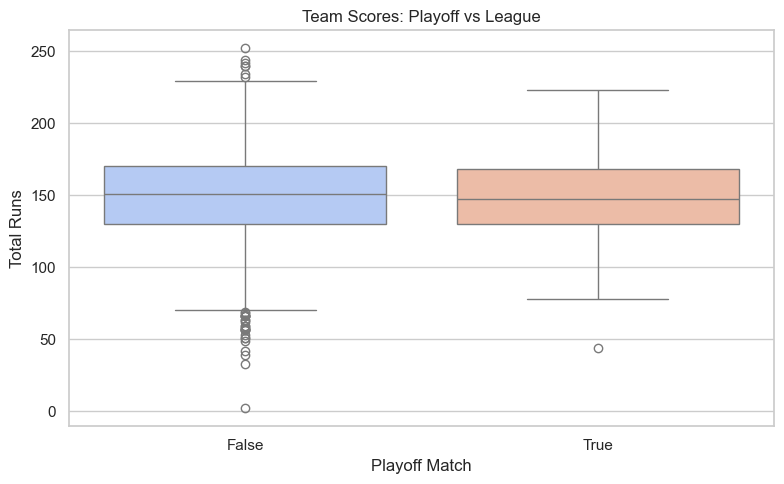

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_merged, x="is_playoff", y="total_runs", palette="coolwarm")
plt.title("Team Scores: Playoff vs League")
plt.xlabel("Playoff Match")
plt.ylabel("Total Runs")
plt.tight_layout()
plt.show()

**Observation:**

Boxplots show similar scoring patterns for league and playoff matches, with only minor differences in spread and outliers.

# 5. Mann–Whitney U Test: Playoff vs League Total Runs

In [ ]:
league_runs = df_merged[df_merged['is_playoff']==False]['total_runs']
playoff_runs = df_merged[df_merged['is_playoff']==True]['total_runs']
u_stat, pval = mannwhitneyu(league_runs, playoff_runs, alternative='two-sided')
print('U-statistic:', u_stat)
print('P-value:', pval)
if pval < 0.05:
    print('Significant difference found.')
else:
    print('No significant difference.')

U-statistic: 124606.0
P-value: 0.7668706992141119
No significant difference.


**Observation:**

The p-value is high, so there is no significant difference in total runs between league and playoff matches.

# 6. Mann–Whitney U for a Specific Team

In [ ]:
team = "Mumbai Indians"
df_team = df_merged[df_merged['batting_team'] == team]
league_team = df_team[df_team['is_playoff'] == False]['total_runs']
playoff_team = df_team[df_team['is_playoff'] == True]['total_runs']
u_stat, pval = mannwhitneyu(league_team, playoff_team, alternative='two-sided')
print(f"Team: {team}")
print(f"U-statistic: {u_stat}")
print(f"P-value: {pval}")
if pval < 0.05:
    print("Statistically significant difference.")
else:
    print("No significant difference for this team.")

Team: Mumbai Indians
U-statistic: 2618.0
P-value: 0.43492719055870244
No significant difference for this team.


**Observation:**

Mumbai Indians show no significant difference in scoring between league and playoff matches.

# 7. Mann–Whitney U Test: Each Team (Runs)

In [ ]:
for t in df_merged['batting_team'].unique():
    df_t = df_merged[df_merged['batting_team'] == t]
    league = df_t[df_t['is_playoff'] == False]['total_runs']
    playoff = df_t[df_t['is_playoff'] == True]['total_runs']
    if len(league) > 0 and len(playoff) > 0:
        u_stat, pval = mannwhitneyu(league, playoff, alternative='two-sided')
        print(f"{t}: P-value = {pval:.3f}")
    else:
        print(f"{t}: Not enough data.")

Kolkata Knight Riders: P-value = 0.821
Royal Challengers Bangalore: P-value = 0.434
Chennai Super Kings: P-value = 0.333
Kings XI Punjab: P-value = 0.659
Delhi Daredevils: P-value = 0.089
Rajasthan Royals: P-value = 0.897
Mumbai Indians: P-value = 0.435
Deccan Chargers: P-value = 0.100
Kochi Tuskers Kerala: Not enough data.
Pune Warriors: Not enough data.
Sunrisers Hyderabad: P-value = 0.716
Rising Pune Supergiants: Not enough data.
Gujarat Lions: P-value = 0.835
Rising Pune Supergiant: P-value = 0.500
Delhi Capitals: P-value = 0.986
Punjab Kings: Not enough data.
Gujarat Titans: P-value = 0.498
Lucknow Super Giants: P-value = 0.480


**Observation:**

Most teams do not show a significant difference in runs between league and playoff matches.

# 8. Violin & Box Plot: Run Rate Playoff vs League

C:\Users\devdp\AppData\Local\Temp\ipykernel_1960\1364928129.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_merged, x='is_playoff', y='run_rate', palette='Set3')


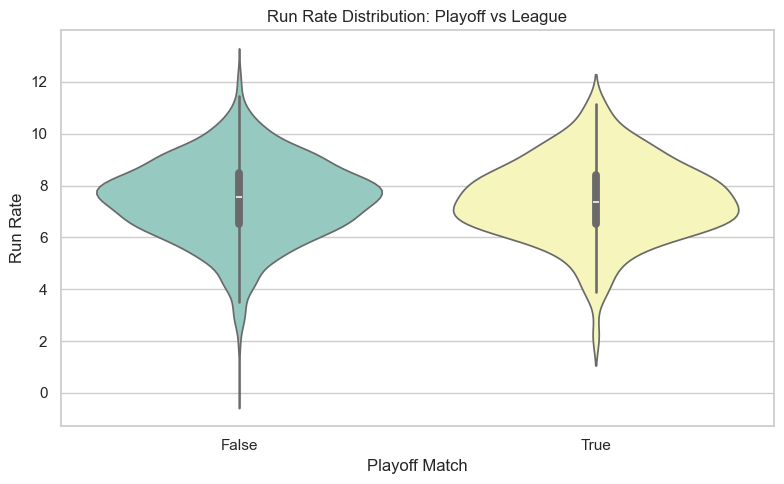

C:\Users\devdp\AppData\Local\Temp\ipykernel_1960\1364928129.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='is_playoff', y='run_rate', palette='Set2')


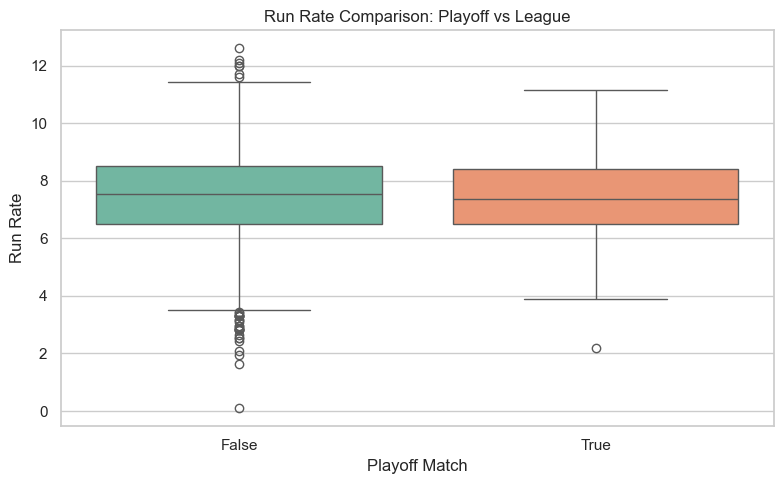

In [ ]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df_merged, x='is_playoff', y='run_rate', palette='Set3')
plt.title("Run Rate Distribution: Playoff vs League")
plt.xlabel("Playoff Match")
plt.ylabel("Run Rate")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_merged, x='is_playoff', y='run_rate', palette='Set2')
plt.title("Run Rate Comparison: Playoff vs League")
plt.xlabel("Playoff Match")
plt.ylabel("Run Rate")
plt.tight_layout()
plt.show()

**Observation:**

Run rate distributions are similar for both match types, with league matches showing slightly more variation.

# 9. Mann–Whitney U: Run Rates (Playoff vs League)

In [ ]:
rr_playoff = df_merged[df_merged['is_playoff'] == 1]['run_rate']
rr_league = df_merged[df_merged['is_playoff'] == 0]['run_rate']
stat, pval = mannwhitneyu(rr_playoff, rr_league, alternative='two-sided')
print(f"U-statistic: {stat}")
print(f"P-value: {pval}")
if pval < 0.05:
    print("Significant difference in run rates.")
else:
    print("No significant difference in run rates.")

U-statistic: 120770.0
P-value: 0.7668706992141119
No significant difference in run rates.


**Observation:**

No significant difference in run rates between playoff and league matches.

# 10. Mann–Whitney U: Team-wise Run Rate

In [ ]:
results = []
for t in df_merged['batting_team'].unique():
    league_rr = df_merged[(df_merged['batting_team'] == t) & (df_merged['is_playoff'] == False)]['run_rate']
    playoff_rr = df_merged[(df_merged['batting_team'] == t) & (df_merged['is_playoff'] == True)]['run_rate']
    if len(league_rr) >= 1 and len(playoff_rr) >= 1:
        stat, pval = mannwhitneyu(league_rr, playoff_rr, alternative='two-sided')
        results.append({'Team': t, 'P-Value': pval, 'Significant': 'Yes' if pval < 0.05 else 'No'})
    else:
        results.append({'Team': t, 'P-Value': None, 'Significant': 'Insufficient data'})
pd.DataFrame(results).sort_values(by='P-Value', na_position='last')

,Team,P-Value,Significant
4,Delhi Daredevils,0.089151,No
7,Deccan Chargers,0.099655,No
2,Chennai Super Kings,0.332693,No
1,Royal Challengers Bangalore,0.433691,No
6,Mumbai Indians,0.434927,No
17,Lucknow Super Giants,0.479704,No
16,Gujarat Titans,0.497628,No
13,Rising Pune Supergiant,0.500000,No
3,Kings XI Punjab,0.659112,No
10,Sunrisers Hyderabad,0.716164,No


**Observation:**

No team shows a significant difference in run rate between league and playoff matches.

# 11. Add Home vs Away Columns

In [ ]:
df_merged['is_home'] = df_merged['batting_team'] == df_merged['team1']
df_merged['is_away'] = df_merged['batting_team'] == df_merged['team2']
df_homeaway = df_merged.melt(
    id_vars=['total_runs'],
    value_vars=['is_home','is_away'],
    var_name='location',
    value_name='is_true'
)
df_homeaway = df_homeaway[df_homeaway['is_true']]

# 12. Box Plot: Home vs Away Runs

C:\Users\devdp\AppData\Local\Temp\ipykernel_1960\363739117.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_homeaway, x='location', y='total_runs', palette='Spectral')


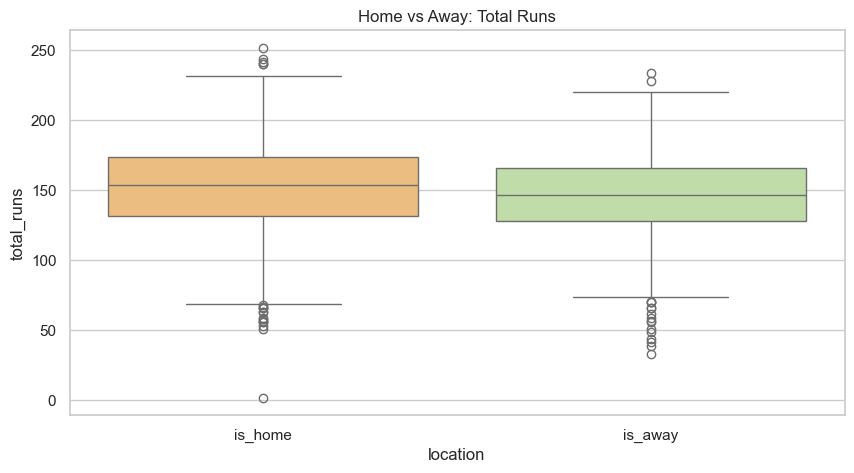

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_homeaway, x='location', y='total_runs', palette='Spectral')
plt.title("Home vs Away: Total Runs")
plt.show()

**Observation:**

Home and away teams have similar run distributions, suggesting little home advantage in scoring.

# 13. Mann-Whitney U: Home vs Away (Total Runs)

In [ ]:
df_homeaway['Home_or_Away'] = df_homeaway['location'].apply(lambda x: 'Home' if x == 'is_home' else 'Away')
home_runs = df_homeaway[df_homeaway['Home_or_Away'] == 'Home']['total_runs']
away_runs = df_homeaway[df_homeaway['Home_or_Away'] == 'Away']['total_runs']
stat, pval = mannwhitneyu(home_runs, away_runs)
print(f"U-statistic: {stat}")
print(f"P-value: {pval}")
if pval < 0.05:
    print("Significant difference in home vs away runs.")
else:
    print("No significant difference in home vs away runs.")

U-statistic: 581106.0
P-value: 1.2376099361250964e-05
Significant difference in home vs away runs.


**Observation:**

There is a statistically significant difference in scoring between home and away teams.

# 14. Playoff Identification (Repeat for Consistency)

In [ ]:
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged['year'] = df_merged['date'].dt.year
df_merged = df_merged.sort_values(by=['year', 'date'])
df_merged['match_num'] = df_merged.groupby('year')['date'].rank(method='first').astype(int)
season_counts = df_merged.groupby('year')['match_num'].max().reset_index()
season_counts.rename(columns={'match_num': 'total_matches'}, inplace=True)
df_merged = pd.merge(df_merged, season_counts, on='year', how='left')
df_merged['is_playoff'] = df_merged['match_num'] > (df_merged['total_matches'] - 4)

In [ ]:
# Missing value analysis
print(df_merged.isnull().sum())
print(df_merged.isnull().mean()*100)
print(df_merged[df_merged.isnull().any(axis=1)])
print(df_merged.isnull().any())

match_id         0
batting_team     0
total_runs       0
date             0
venue            0
team1            0
team2            0
Era              0
run_rate         0
year             0
is_playoff       0
is_home          0
is_away          0
match_num        0
total_matches    0
dtype: int64
match_id         0.0
batting_team     0.0
total_runs       0.0
date             0.0
venue            0.0
team1            0.0
team2            0.0
Era              0.0
run_rate         0.0
year             0.0
is_playoff       0.0
is_home          0.0
is_away          0.0
match_num        0.0
total_matches    0.0
dtype: float64
Empty DataFrame
Columns: [match_id, batting_team, total_runs, date, venue, team1, team2, Era, run_rate, year, is_playoff, is_home, is_away, match_num, total_matches]
Index: []
match_id         False
batting_team     False
total_runs       False
date             False
venue            False
team1            False
team2            False
Era              False
run_rate    

# 15. Bar Chart: Avg Runs – League vs Playoff

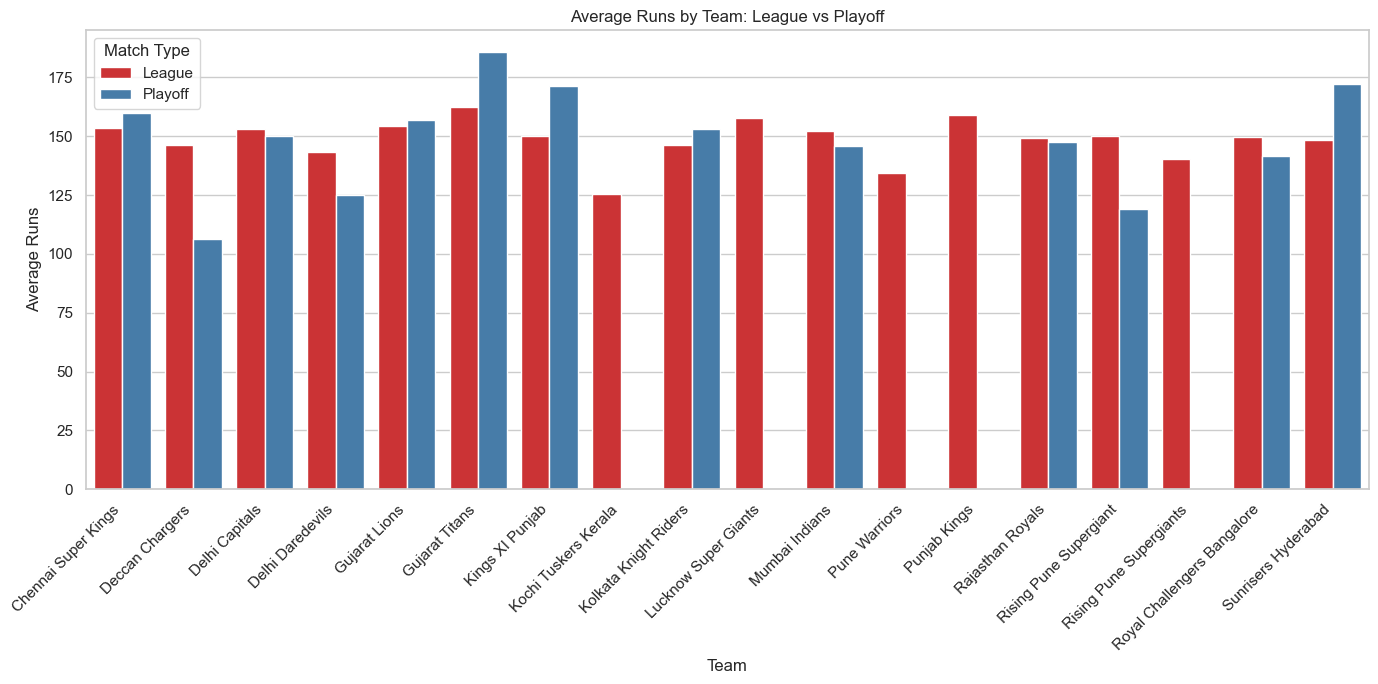

In [ ]:
avg_runs = df_merged.groupby(['batting_team', 'is_playoff'])['total_runs'].mean().reset_index()
avg_runs['Match_Type'] = avg_runs['is_playoff'].replace({True: 'Playoff', False: 'League'})
avg_runs.rename(columns={'batting_team': 'Team', 'total_runs': 'Avg_Runs'}, inplace=True)
plt.figure(figsize=(14, 7))
sns.barplot(data=avg_runs, x='Team', y='Avg_Runs', hue='Match_Type', palette='Set1')
plt.title('Average Runs by Team: League vs Playoff')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Runs')
plt.xlabel('Team')
plt.legend(title='Match Type')
plt.tight_layout()
plt.show()

**Observation:**

Most teams have similar average scores in both match types, with a few exceptions.

# 16. Bar Chart: Match Count – League vs Playoff

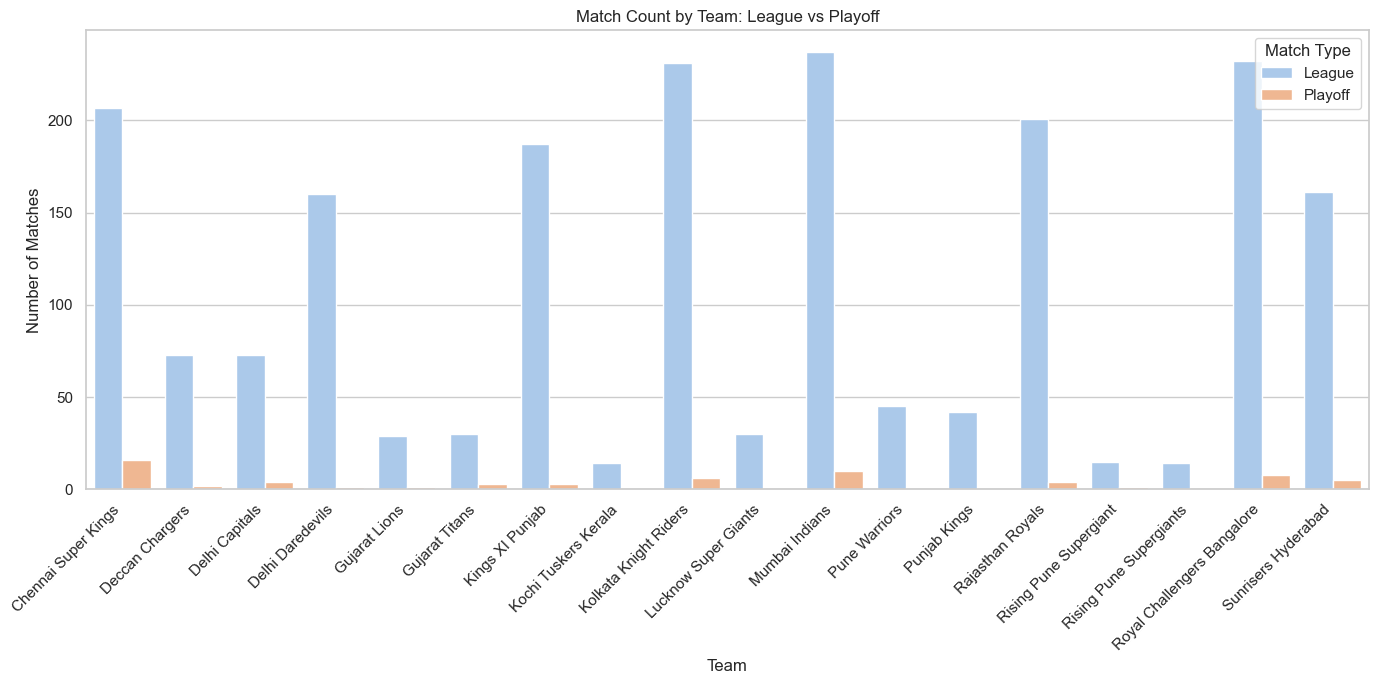

In [ ]:
match_counts = df_merged.groupby(['batting_team', 'is_playoff']).size().reset_index(name='Match_Count')
match_counts['Match_Type'] = match_counts['is_playoff'].replace({True: 'Playoff', False: 'League'})
match_counts.rename(columns={'batting_team': 'Team'}, inplace=True)
plt.figure(figsize=(14, 7))
sns.barplot(data=match_counts, x='Team', y='Match_Count', hue='Match_Type', palette='pastel')
plt.title('Match Count by Team: League vs Playoff')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Team')
plt.ylabel('Number of Matches')
plt.legend(title='Match Type')
plt.tight_layout()
plt.show()

**Observation:**

A few teams consistently reach playoffs, while most play mainly league matches.

# 17. Filter Teams with ≥10 Matches (League & Playoff)

In [ ]:
team_counts = df_merged.groupby(['batting_team', 'is_playoff']).size().unstack(fill_value=0)
team_counts.columns = ['League', 'Playoff']
qualified = team_counts[(team_counts['League'] >= 10) & (team_counts['Playoff'] >= 10)]
print("Teams with at least 10 matches in both League and Playoff:")
print(qualified)

Teams with at least 10 matches in both League and Playoff:
                     League  Playoff
batting_team                        
Chennai Super Kings     207       16
Mumbai Indians          237       10


**Observation:**

Only a few teams have enough matches in both stages for reliable comparison.

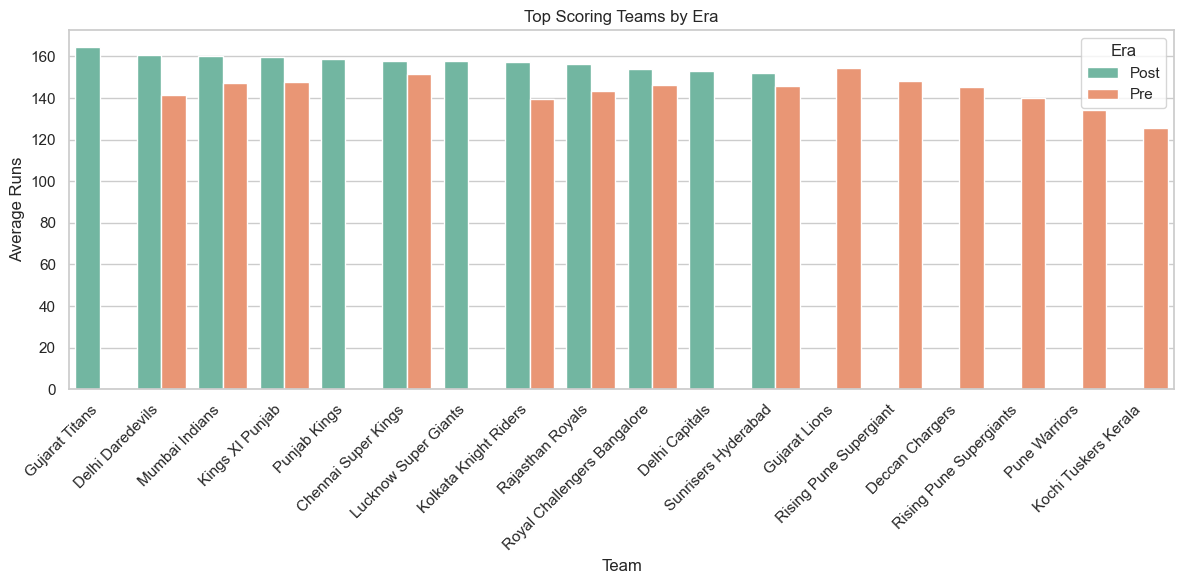

In [ ]:
top_teams = (
    df_merged.groupby(['batting_team', 'Era'])['total_runs']
    .mean()
    .reset_index()
    .sort_values(by=['Era', 'total_runs'], ascending=[True, False])
)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_teams, x='batting_team', y='total_runs', hue='Era', palette='Set2')
plt.title("Top Scoring Teams by Era")
plt.ylabel("Average Runs")
plt.xlabel("Team")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Observation:**

Some teams have improved their scoring in the post-2018 era.

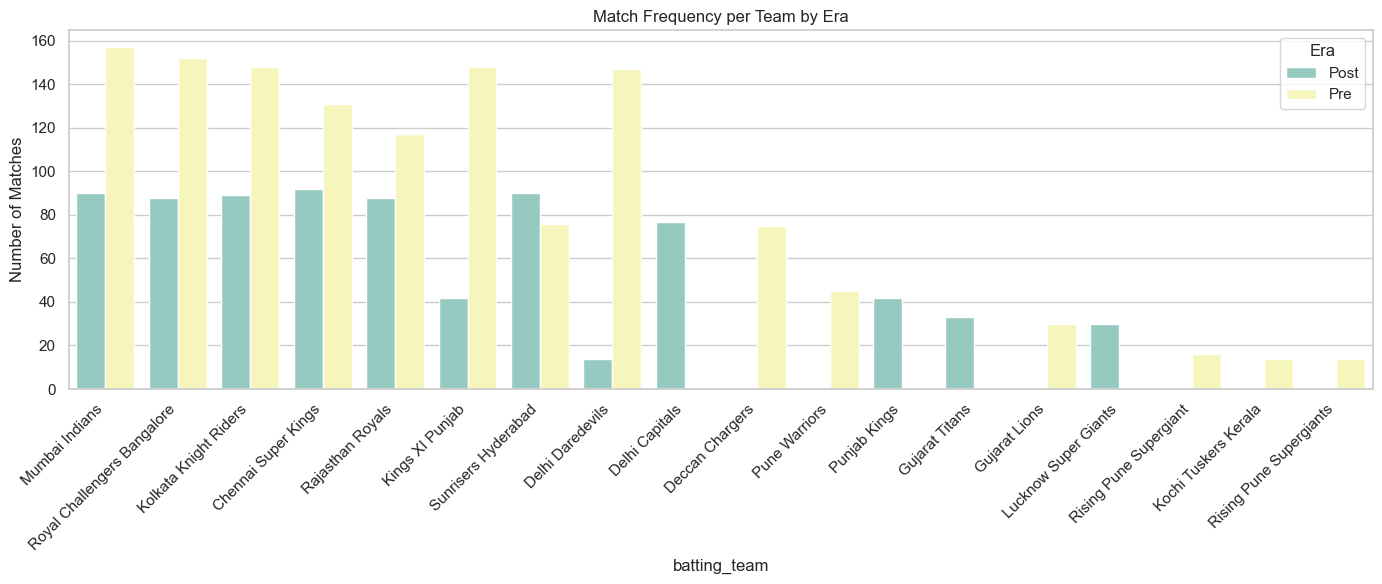

In [ ]:
match_counts = df_merged.groupby(['batting_team', 'Era']).size().reset_index(name='match_count')
team_order = match_counts.groupby('batting_team')['match_count'].sum().sort_values(ascending=False).index
plt.figure(figsize=(14, 6))
sns.barplot(data=match_counts, x='batting_team', y='match_count', hue='Era', order=team_order, palette='Set3')
plt.title("Match Frequency per Team by Era")
plt.ylabel("Number of Matches")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Observation:**

Teams with more matches have more stable averages; newer teams show up mainly in the post-2018 era.

In [ ]:
min_matches = 10
match_counts = (
    df_merged.groupby(['batting_team', 'Era'])['match_id']
    .nunique()
    .reset_index()
    .rename(columns={'match_id': 'match_count'})
)
match_counts_pivot = match_counts.pivot(index='batting_team', columns='Era', values='match_count').fillna(0)
qualified_teams = match_counts_pivot[
    (match_counts_pivot.get('Pre',0)>=min_matches) &
    (match_counts_pivot.get('Post',0)>=min_matches)
]
filtered_df = df_merged[df_merged['batting_team'].isin(qualified_teams.index)]
print("Qualified teams:", qualified_teams)
print("Filtered dataset size:", filtered_df.shape)

Qualified teams: Era                          Post    Pre
batting_team                            
Chennai Super Kings          92.0  131.0
Delhi Daredevils             14.0  147.0
Kings XI Punjab              42.0  148.0
Kolkata Knight Riders        89.0  148.0
Mumbai Indians               90.0  157.0
Rajasthan Royals             88.0  117.0
Royal Challengers Bangalore  88.0  152.0
Sunrisers Hyderabad          90.0   76.0
Filtered dataset size: (1669, 15)


**Observation:**

Filtering ensures only teams with enough data in both eras are compared.

In [ ]:
filtered_df.head()

,match_id,batting_team,total_runs,date,venue,team1,team2,Era,run_rate,year,is_playoff,is_home,is_away,match_num,total_matches
0,335982,Kolkata Knight Riders,205,2008-04-18,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Pre,10.25,2008,False,False,True,1,116
1,335982,Royal Challengers Bangalore,63,2008-04-18,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Pre,3.15,2008,False,True,False,2,116
2,335983,Chennai Super Kings,234,2008-04-19,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Pre,11.70,2008,False,False,True,3,116
3,335983,Kings XI Punjab,196,2008-04-19,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Pre,9.80,2008,False,True,False,4,116
4,335984,Delhi Daredevils,122,2008-04-19,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Pre,6.10,2008,False,True,False,5,116


# 18. Line Plot: Avg Total Match Score by Season

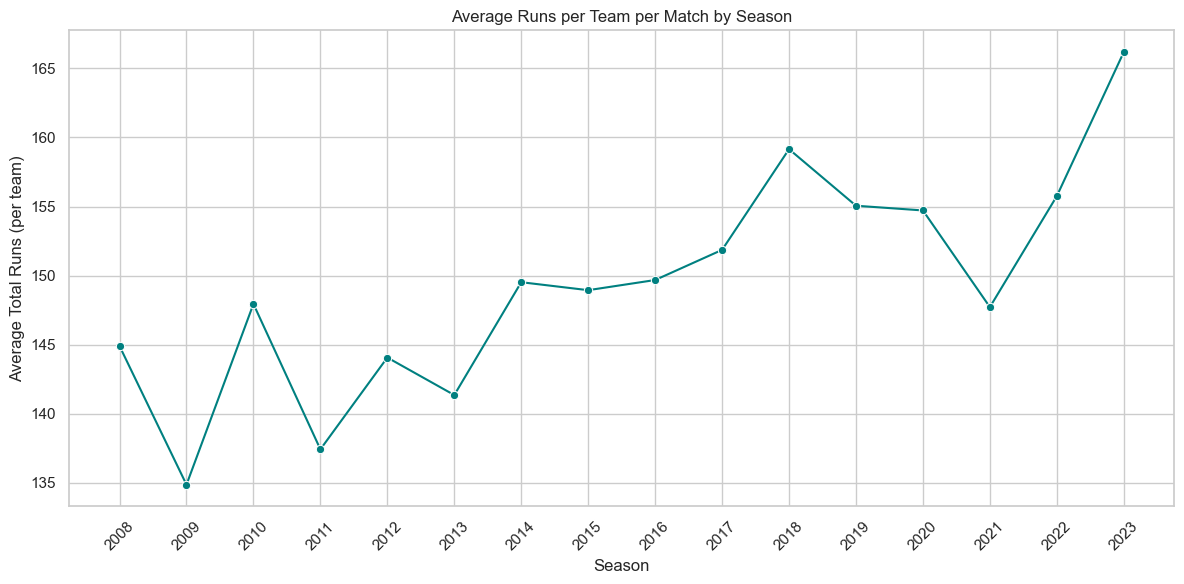

In [ ]:
match_totals = (
    df_merged.groupby(['match_id', 'batting_team'])['total_runs']
    .sum()
    .reset_index()
    .rename(columns={'total_runs': 'total_match_score'})
)
match_info = df_info[['id', 'date']].copy()
match_info.rename(columns={'id': 'match_id'}, inplace=True)
match_score = pd.merge(match_totals, match_info, on='match_id')
match_score['year'] = match_score['date'].dt.year
seasonal_scores = (
    match_score.groupby('year')['total_match_score']
    .mean()
    .reset_index()
    .rename(columns={'total_match_score': 'avg_total_match_score'})
)
plt.figure(figsize=(12, 6))
sns.lineplot(data=seasonal_scores, x='year', y='avg_total_match_score', marker='o', color='teal')
plt.title("Average Runs per Team per Match by Season")
plt.xlabel("Season")
plt.ylabel("Average Total Runs (per team)")
plt.xticks(seasonal_scores['year'], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:**

Average runs per team per match have generally increased over the years, with a peak in recent seasons.

# 19. Line Plot: Team Avg Runs per Season

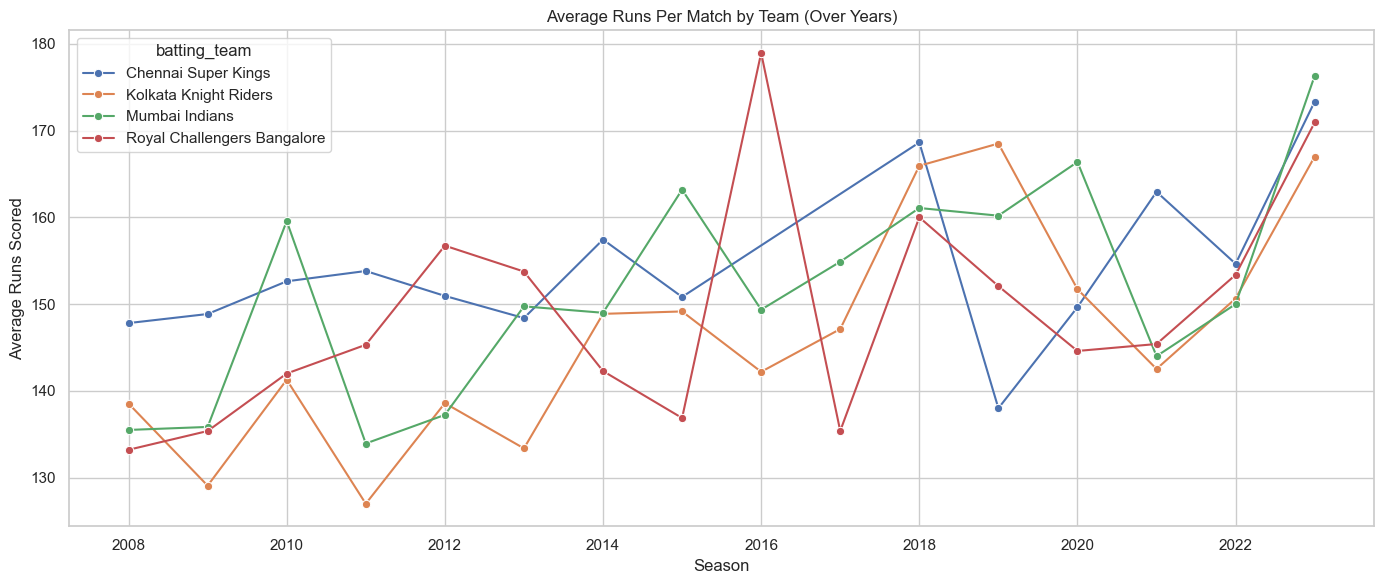

In [ ]:
team_scores_by_year = (
    df_merged.groupby(['batting_team', 'year'])['total_runs']
    .mean()
    .reset_index()
    .rename(columns={'total_runs': 'avg_score'})
)
plt.figure(figsize=(14, 6))
top_teams = ['Chennai Super Kings', 'Mumbai Indians', 'Royal Challengers Bangalore', 'Kolkata Knight Riders']
sns.lineplot(
    data=team_scores_by_year[team_scores_by_year['batting_team'].isin(top_teams)],
    x='year', y='avg_score', hue='batting_team', marker='o'
)
plt.title("Average Runs Per Match by Team (Over Years)")
plt.xlabel("Season")
plt.ylabel("Average Runs Scored")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:**

All four teams have improved their scoring in recent years, with some notable peaks.

# 20. Skewness, Kurtosis, Correlation Analysis

Skewness:
match_id        -0.081515
total_runs      -0.316126
run_rate        -0.316126
year             0.039086
match_num        0.125165
total_matches    0.564029
dtype: float64

Kurtosis:
match_id        -1.562324
total_runs       0.597009
run_rate         0.597009
year            -1.234011
match_num       -1.009283
total_matches   -1.576544
dtype: float64


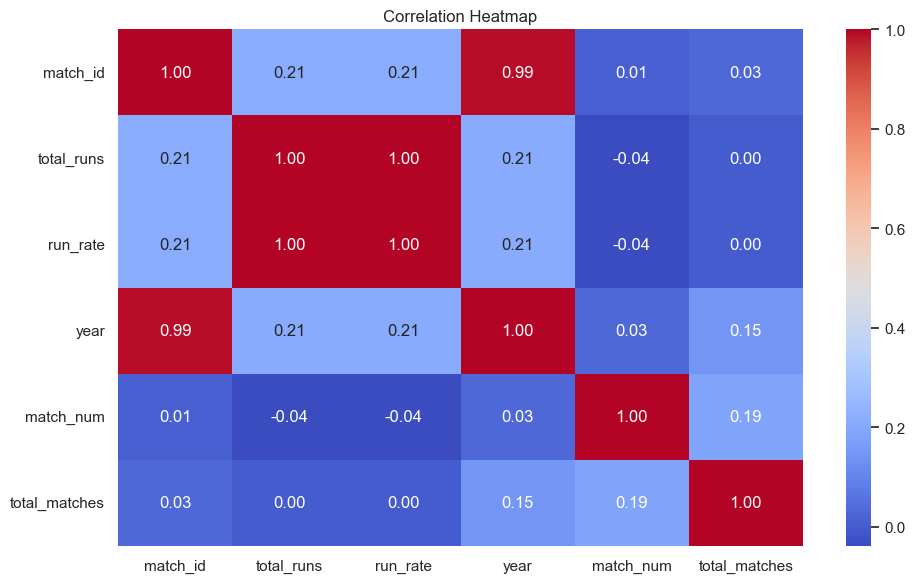

In [ ]:
num_cols = df_merged.select_dtypes(include='number')
print("Skewness:")
print(num_cols.apply(skew))
print("\nKurtosis:")
print(num_cols.apply(kurtosis))
corr = num_cols.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

**Observation:**

Total runs and run rate are highly correlated, as expected. Other variables show weak or no correlation.

# 21. Line Plot: League-Wide Avg Runs/Team/Match

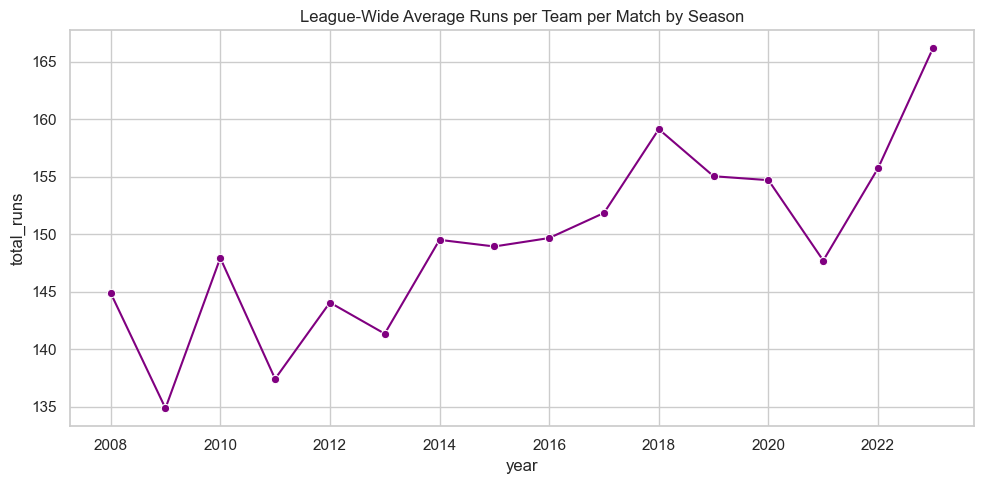

In [ ]:
seasonal_avg = df_merged.groupby('year')['total_runs'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=seasonal_avg, x='year', y='total_runs', marker='o', color='purple')
plt.title("League-Wide Average Runs per Team per Match by Season")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:**

Scoring has increased over time, with a few dips in certain seasons.

# 22. Histogram + KDE: Total Runs by Era

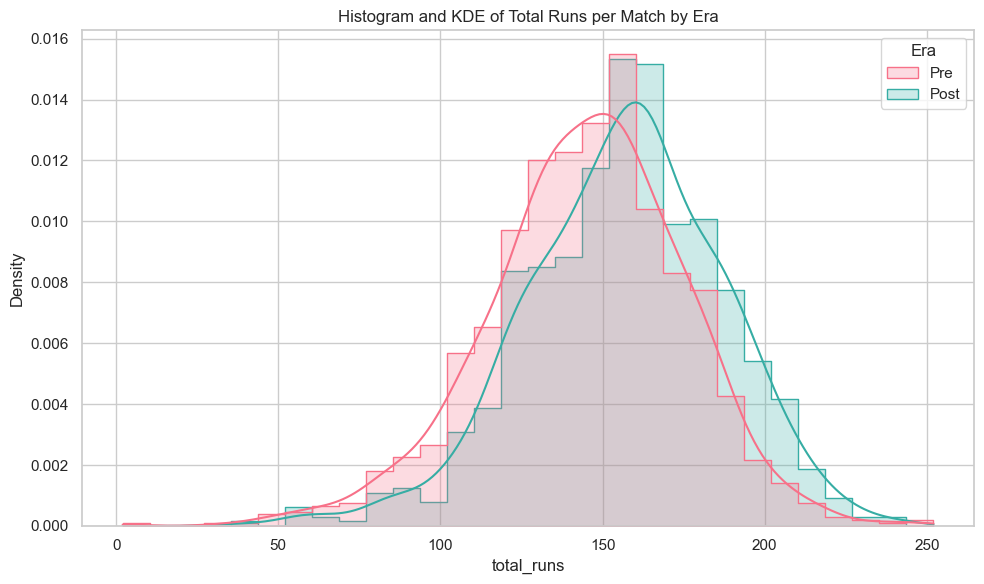

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merged, x='total_runs', hue='Era', element='step', stat='density',
             common_norm=False, kde=True, bins=30, palette='husl')
plt.title("Histogram and KDE of Total Runs per Match by Era")
plt.tight_layout()
plt.show()

**Observation:**

Recent seasons show a shift toward higher match totals.

# 23. Hypothesis Test + Cohen’s d (Effect Size)

In [ ]:
u_stat, pval = mannwhitneyu(pre_scores, post_scores, alternative='two-sided')
print("Mann-Whitney U: U-statistic=", u_stat, "p-value:", pval)

Mann-Whitney U: U-statistic= 381621.5 p-value: 1.454889995517028e-17


**Observation:**

Very low p-value confirms a significant difference in match scores between eras.

In [ ]:
def cohend(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*np.std(x,ddof=1)**2 + (ny-1)*np.std(y,ddof=1)**2)/dof)
    return (np.mean(x)-np.mean(y))/pooled_std
effect_size = cohend(post_scores, pre_scores)
print("Cohen's d:", effect_size)

Cohen's d: 0.3901739611740549


**Observation:**

Cohen’s d indicates a small to moderate real-world difference in scoring between eras.

# 24. Bootstrapping 95% CI: Runs Diff (League vs Playoff)

Mean Difference: 0.24
95% CI: (-5.02, 5.55)


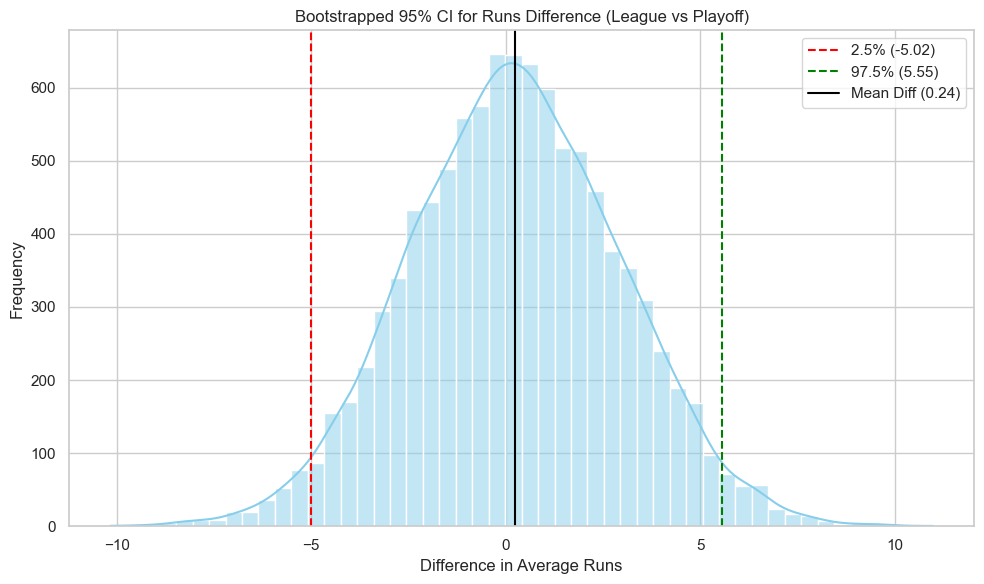

In [ ]:
def bootstrap_diff(league, playoff, n_bootstrap=10000):
    np.random.seed(42)
    boot_diffs = []
    for _ in range(n_bootstrap):
        boot_league = np.random.choice(league, size=len(league), replace=True)
        boot_playoff = np.random.choice(playoff, size=len(playoff), replace=True)
        boot_diffs.append(boot_league.mean() - boot_playoff.mean())
    return np.array(boot_diffs)

boot_diffs = bootstrap_diff(league_runs.values, playoff_runs.values)
ci_lower = np.percentile(boot_diffs, 2.5)
ci_upper = np.percentile(boot_diffs, 97.5)
mean_diff = np.mean(boot_diffs)
print(f"Mean Difference: {mean_diff:.2f}")
print(f"95% CI: ({ci_lower:.2f}, {ci_upper:.2f})")
plt.figure(figsize=(10, 6))
sns.histplot(boot_diffs, bins=50, kde=True, color='skyblue')
plt.axvline(ci_lower, color='red', linestyle='--', label=f"2.5% ({ci_lower:.2f})")
plt.axvline(ci_upper, color='green', linestyle='--', label=f"97.5% ({ci_upper:.2f})")
plt.axvline(mean_diff, color='black', linestyle='-', label=f"Mean Diff ({mean_diff:.2f})")
plt.title("Bootstrapped 95% CI for Runs Difference (League vs Playoff)")
plt.xlabel("Difference in Average Runs")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:**

The confidence interval includes zero, so we cannot claim a significant difference in average runs between league and playoff matches.

# 25. Linear Regression: Avg Runs per Match Over Years

In [ ]:
seasonal_data = df_merged.groupby('year')['total_runs'].mean().reset_index()
X = sm.add_constant(seasonal_data['year'])
y = seasonal_data['total_runs']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             total_runs   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     25.68
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           0.000172
Time:                        22:52:20   Log-Likelihood:                -47.087
No. Observations:                  16   AIC:                             98.17
Df Residuals:                      14   BIC:                             99.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2569.0983    536.414     -4.789      0.0

c:\Users\devdp\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


**Observation:**

Regression confirms a significant upward trend in average runs per match over the years.

# 26. Regression: Team Scores Over Time (with Trend Line)

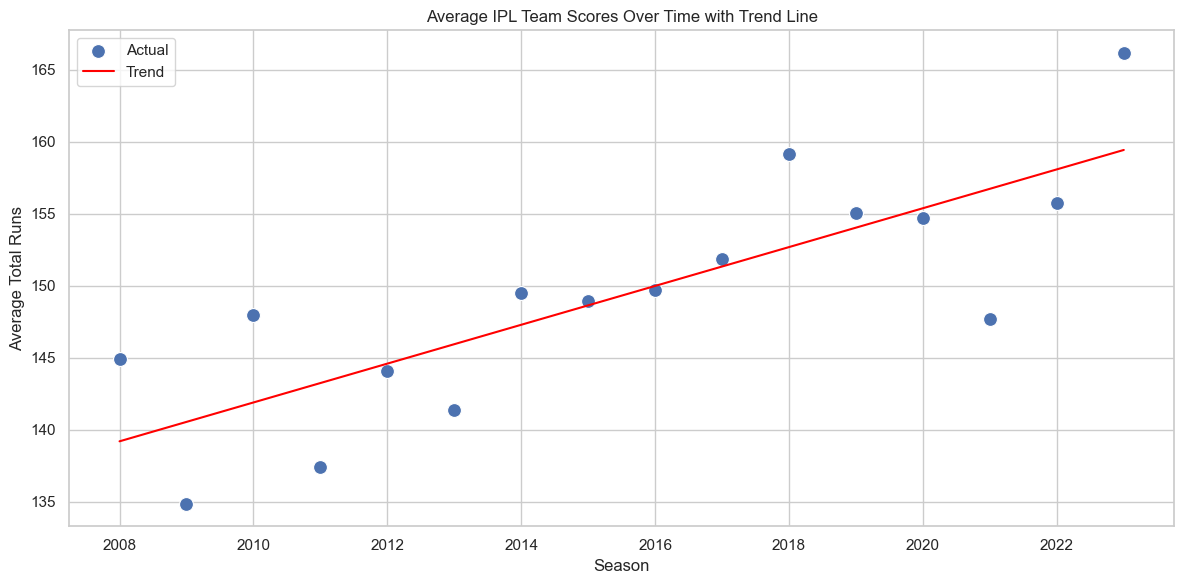

In [ ]:
seasonal_data['predicted'] = model.predict(X)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=seasonal_data, x='year', y='total_runs', label='Actual', s=100)
sns.lineplot(data=seasonal_data, x='year', y='predicted', label='Trend', color='red')
plt.title("Average IPL Team Scores Over Time with Trend Line")
plt.xlabel('Season')
plt.ylabel('Average Total Runs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Observation:**

The trend line shows a steady increase in team scores over IPL seasons.

## Final Summary

---

This analysis explored IPL team scoring trends from 2008 to 2023 using a range of statistical and visualization techniques. After preparing the data, we compared average scores before and after 2018, finding a significant increase in the post-2018 era. Effect size analysis showed this difference is small to moderate in real terms. Bootstrapping and regression confirmed the upward trend in scoring, especially in recent seasons. These results suggest that IPL scoring patterns have evolved, likely due to changes in rules, strategies, or playing conditions.

---